In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import datetime
import re
from elasticsearch import Elasticsearch, exceptions as es_exceptions
from elasticsearch.helpers import scan
es = Elasticsearch(hosts=[{'host':'atlas-kibana-dev.mwt2.org', 'port':9200}],timeout=60)

In [2]:
indices = es.cat.indices(index="jobs_archive_*", h="index", request_timeout=600).split('\n')
indices = sorted(indices)
indices = [x for x in indices if x != '']
print(indices)

['jobs_archive_2016-01-01_reindexed', 'jobs_archive_2016-01-02_reindexed', 'jobs_archive_2016-01-03_reindexed', 'jobs_archive_2016-01-04_reindexed', 'jobs_archive_2016-01-05_reindexed', 'jobs_archive_2016-01-06_reindexed', 'jobs_archive_2016-01-07_reindexed', 'jobs_archive_2016-01-08_reindexed', 'jobs_archive_2016-01-09_reindexed', 'jobs_archive_2016-01-10_reindexed', 'jobs_archive_2016-01-11_reindexed', 'jobs_archive_2016-01-12_reindexed', 'jobs_archive_2016-01-13_reindexed', 'jobs_archive_2016-01-14_reindexed', 'jobs_archive_2016-01-15_reindexed', 'jobs_archive_2016-01-16_reindexed', 'jobs_archive_2016-01-17_reindexed', 'jobs_archive_2016-01-18_reindexed', 'jobs_archive_2016-01-19_reindexed', 'jobs_archive_2016-01-20_reindexed', 'jobs_archive_2016-01-21_reindexed', 'jobs_archive_2016-01-22_reindexed', 'jobs_archive_2016-01-23_reindexed', 'jobs_archive_2016-01-24_reindexed', 'jobs_archive_2016-01-25_reindexed', 'jobs_archive_2016-01-26_reindexed', 'jobs_archive_2016-01-27_reindexed', 

In [3]:
def time_filter(indices, last_days=1, pattern=''):
    if last_days == 0:
        return ["jobs_archive_*"]
    filtered = []
    if pattern:
        for i in indices:
            if pattern in i:
                filtered.append(i.rstrip())
        return filtered
    today = datetime.date.today()
    filtered = []
    datefmt = '%Y-%m-%d'
    for i in indices:
        day = re.sub(r'jobs_archive_', '', i).rstrip()
        day = datetime.datetime.strptime(day, datefmt).date()
        diff = today - day
        if diff.days <= last_days:
            filtered.append(i.rstrip())
    return filtered

In [5]:
ind1 = time_filter(indices, 60, "jobs_archive_2017-02-" )
ind1 = ','.join(ind1)
ind2 = time_filter(indices, 60, "jobs_archive_2017-03-" )
ind2 = ','.join(ind2)
ind3 = time_filter(indices, 60, "jobs_archive_2017-04-" )
ind3 = ','.join(ind3)
ind4 = time_filter(indices, 60, "jobs_archive_2017-05-" )
ind4 = ','.join(ind4)
ind5 = time_filter(indices, 60, "jobs_archive_2017-06-" )
ind5 = ','.join(ind5)
ind6 = time_filter(indices, 60, "jobs_archive_2017-07-" )
ind6 = ','.join(ind6)
#ind = ind1+","+ind2+","+ind3+","+ind4+","+ind5+","+ind6
ind = ind6

print(ind)

jobs_archive_2017-07-01,jobs_archive_2017-07-02,jobs_archive_2017-07-03,jobs_archive_2017-07-04,jobs_archive_2017-07-05,jobs_archive_2017-07-06,jobs_archive_2017-07-07,jobs_archive_2017-07-08,jobs_archive_2017-07-09,jobs_archive_2017-07-10,jobs_archive_2017-07-11,jobs_archive_2017-07-12,jobs_archive_2017-07-13,jobs_archive_2017-07-14,jobs_archive_2017-07-15,jobs_archive_2017-07-16,jobs_archive_2017-07-17,jobs_archive_2017-07-18,jobs_archive_2017-07-19,jobs_archive_2017-07-20,jobs_archive_2017-07-21


In [6]:
#q = "NOT produsername:gangarbt AND jobstatus:finished AND processingtype:reprocessing AND proddblock:*.00283429.*"
#q = "NOT produsername:gangarbt AND jobstatus:finished AND processingtype:pile"
q = "NOT produsername:gangarbt AND jobstatus:finished AND NOT transformation:*pandaserver* AND pilotid:*68.0* AND processingtype:reprocessing"

In [7]:
myqueryBOINC_CHECKPOINT = {
  "query": {
    "bool": {
      "must": [
        {
          "query_string": {
            "query": "jeditaskid:11589291 AND jobstatus:finished AND modificationhost:*Yeti@ATLAS*",
            "analyze_wildcard": True,
            "lowercase_expanded_terms": False
          }
        },
      ],
      "must_not": []
    }
  },
  "aggs": {
    "2": {
      "histogram": {
        "script": {
          "inline": "(doc['nevents'].value && doc['actualcorecount'].value) ? doc['timeExe'].value*doc['actualcorecount'].value/doc['nevents'].value : 0",
          "lang": "expression"
        },
        "interval": 10,
        "min_doc_count": 1
      },
        "aggs": {
            "3": {
          "significant_terms": {
            "field": "modificationhost",
            "size": 1000
          }
        }
      }

    }
  }
}

myqueryBOINC_CHECKPOINT_CPUEFF = {
  "query": {
    "bool": {
      "must": [
        {
          "query_string": {
            "query": "jeditaskid:11589291 AND jobstatus:finished AND modificationhost:MAGIC_Quantum_Mechanic@HAL_5778xx",
            "analyze_wildcard": True,
            "lowercase_expanded_terms": False
          }
        },
      ],
      "must_not": []
    }
  },
  "aggs": {
    "2": {
      "histogram": {
        "script": {
          "inline": "(doc['cpu_eff'].value && doc['actualcorecount'].value) ? doc['cpu_eff'].value/doc['actualcorecount'].value*100 : 0",
          "lang": "expression"
        },
        "interval": 1,
        "min_doc_count": 1
      },
        "aggs": {
            "3": {
          "significant_terms": {
            "field": "modificationhost",
            "size": 1000
          }
        }
      }

    }
  }
}


myqueryBOINC = {
  "query": {
    "bool": {
      "must": [
        {
          "query_string": {
            "query": "jeditaskid:11364822 AND jobstatus:finished",
            "analyze_wildcard": True,
            "lowercase_expanded_terms": False
          }
        },
      ],
      "must_not": []
    }
  },
  "aggs": {
    "2": {
      "histogram": {
        "script": {
          "inline": "(doc['nevents'].value && doc['actualcorecount'].value) ? doc['wall_time'].value*doc['actualcorecount'].value/doc['nevents'].value : 0",
          "lang": "expression"
        },
        "interval": 10,
        "min_doc_count": 1
      },
        "aggs": {
            "3": {
          "significant_terms": {
            "field": "modificationhost",
            "size": 1000
          }
        }
      }

    }
  }
}


myqueryBOINC_CPUEFF = {
  "query": {
    "bool": {
      "must": [
        {
          "query_string": {
            "query": "jeditaskid:11364822 AND jobstatus:finished AND modificationhost:*Yeti@ATLAS1*",
            "analyze_wildcard": True,
            "lowercase_expanded_terms": False
          }
        },
      ],
      "must_not": []
    }
  },
  "aggs": {
    "2": {
      "histogram": {
        "script": {
          "inline": "(doc['cpu_eff'].value && doc['actualcorecount'].value) ? doc['cpu_eff'].value/doc['actualcorecount'].value*100 : 0",
          "lang": "expression"
        },
        "interval": 1,
        "min_doc_count": 1
      },
        "aggs": {
            "3": {
          "significant_terms": {
            "field": "modificationhost",
            "size": 1000
          }
        }
      }

    }
  }
}




In [8]:
res = es.search(index=ind, body=myqueryBOINC, request_timeout=600)

In [9]:
print(res)

{'took': 78, '_shards': {'failed': 0, 'total': 105, 'successful': 105}, 'timed_out': False, 'aggregations': {'2': {'buckets': [{'3': {'bg_count': 379382, 'buckets': [], 'doc_count': 1}, 'key': 160.0, 'doc_count': 1}, {'3': {'bg_count': 395658, 'buckets': [], 'doc_count': 1}, 'key': 170.0, 'doc_count': 1}, {'3': {'bg_count': 771905, 'buckets': [], 'doc_count': 2}, 'key': 190.0, 'doc_count': 2}, {'3': {'bg_count': 4820564, 'buckets': [{'bg_count': 28, 'score': 19128.888888888887, 'key': 'MPI_f&#195;&#188;r_Physik@pcl132a', 'doc_count': 4}, {'bg_count': 21, 'score': 14346.666666666666, 'key': 'Rodney.Walker@gar-ws-etp95', 'doc_count': 3}], 'doc_count': 12}, 'key': 200.0, 'doc_count': 12}, {'3': {'bg_count': 4612064, 'buckets': [{'bg_count': 21, 'score': 15617.304550264551, 'key': 'MPI_f&#195;&#188;r_Physik@pcatlas25', 'doc_count': 4}], 'doc_count': 15}, 'key': 210.0, 'doc_count': 15}, {'3': {'bg_count': 8434339, 'buckets': [{'bg_count': 18, 'score': 8713.023760330578, 'key': 'MPI_f&#195;&

32.266891891891895 592 19102
40 7
137 18
MPI_f&#195;&#188;r_Physik@pcl132a 592
Rodney.Walker@gar-ws-etp95 591
MPI_f&#195;&#188;r_Physik@pcatlas25 534
MPI_f&#195;&#188;r_Physik@pcatlas19 581
MPI_f&#195;&#188;r_Physik@pcatlas21 582
Toby_Broom@Desktop 528
MPI_f&#195;&#188;r_Physik@pcatlas38 534
MPI_f&#195;&#188;r_Physik@pcatlas56 563
MPI_f&#195;&#188;r_Physik@pcatlas37 563
MPI_f&#195;&#188;r_Physik@pcatlas29 572
Claus_Varming_Lund@Claus-WorkST-PC 518
Yeti@AHuW101 566
Yeti@AHuW74 567
HerveUAE@Potosi 584
Andy_W@MediaPlayer3 592
Ivy-Mike@Ivy-MIke 592
Gunde@ws01-Linux 590
Gunde@ws02-Linux 596
MPI_f&#195;&#188;r_Physik@pcl132a mean = 833.3614864864865
Rodney.Walker@gar-ws-etp95 mean = 834.4331641285956
MPI_f&#195;&#188;r_Physik@pcatlas25 mean = 898.183520599251
MPI_f&#195;&#188;r_Physik@pcatlas19 mean = 844.6987951807229
MPI_f&#195;&#188;r_Physik@pcatlas21 mean = 843.3161512027491
Toby_Broom@Desktop mean = 902.6704545454545
MPI_f&#195;&#188;r_Physik@pcatlas38 mean = 896.6666666666666
MPI_f&#19

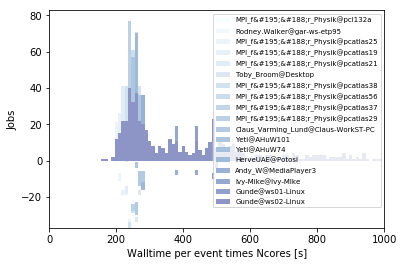

In [11]:
hists = []
xbins = []
rels = []

#hists =[[]]
#rels = ['All sites']

# First loop: determine AtlasRelease numbers and initialize histograms
for r in res['aggregations']['2']['buckets']:
    for e in r['3']['buckets']:
        if not e['key'] in rels:
            rels.append(e['key'])
            hists.append([])

# Now loop again and fill the histogram bins            
xbin = 0
for r in res['aggregations']['2']['buckets']:
    x = r['key']
    #print(x)
    #print(r['doc_count'])
    #if x>199: # This is the x-axis cut for inputfilebytes !
    #if x>199: # This is the x-axis cut for total !
    #if x>17.9: # This is the x-axis cut for rate !
    #if (x<60 or x>240):
    #    continue
    xbins.append(x)
    for hist in hists:
        hist.append(r['doc_count'])
    for e in r['3']['buckets']:
        #print(e)
        for rel, hist in zip(rels,hists):
            if e['key'] == rel:
                hist[xbin] = e['doc_count']       
    xbin = xbin + 1

#print(hists)

allsites = hists[0]
ibin = 0
sum = 0
wsum = 0
max = 0
for bin in allsites:
    if bin > max:
        max = bin
        maxbin = ibin
    sum = sum + bin
    wsum = wsum + bin * ibin
    ibin = ibin +1

mean = wsum/sum
print (mean, sum, wsum)
print (max, maxbin)
print(len(xbins),len(hists))

# Initialisation for histogram stacking
y_offset = np.array([0.0] * len(xbins))
colors = plt.cm.BuPu(np.linspace(0, 0.5, len(hists)))
#allcolors = ('#ff3333', '#33ff33', '#3333ff', '#33ffff', "#ffffff", '#000000', '#ff0000', '#00ff00', '#0000ff')
#allcolors = ('accent', 'dark2', 'paired', 'pastel1','pastel2', 'set1', 'set2', 'set3', 'vega10','vega20', 'vega20b', 'vega20c')
#allcolors = [u'#4B0082', u'#FFD700', u'#FF69B4', u'#B22222', u'#CD5C5C', u'#87AE73', u'#FFFF00', u'#FFE4E1', u'#556B2F', u'#808000', u'#8FBC8F', u'#FFC0CB', u'#FF6347', u'#F08080', u'#FF4500', u'#FFDEAD', u'#00FF00', u'#98FB98', u'#2F4F4F', u'#ADFF2F', u'#DEB887', u'#FFF5EE', u'#00FA9A', u'#FF00FF', u'#FFEFD5', u'#FFEBCD', u'#7FFF00', u'#696969', u'#000000', u'#FFDAB9', u'#00FF7F', u'#7FFFD4', u'#FFFFFF', u'#FFA500', u'#FFA07A', u'#2F4F4F', u'#A52A2A', u'#FFFFF0', u'#1E90FF', u'#CD853F', u'#A9A9A9', u'#7CFC00', u'#D2691E', u'#DC143C', u'#228B22', u'#6A5ACD', u'#20B2AA', u'#00FFFF', u'#F5FFFA', u'#C0C0C0', u'#FAEBD7', u'#BA55D3', u'#87CEEB', u'#808080', u'#00CED1', u'#DAA520', u'#006400', u'#FFFAF0', u'#9400D3', u'#A9A9A9', u'#FFE4B5', u'#8B4513', u'#808080', u'#483D8B', u'#87CEFA', u'#FFB6C1', u'#C71585', u'#708090', u'#FF0000', u'#FF1493', u'#32CD32', u'#8B008B', u'#EEE8AA', u'#DDA0DD', u'#40E0D0', u'#D3D3D3', u'#FAFAD2', u'#B8860B', u'#E6E6FA', u'#800000', u'#9ACD32', u'#FAA460', u'#D8BFD8', u'#EE82EE', u'#000080', u'#FF00FF', u'#696969', u'#D2B48C', u'#BC8F8F', u'#6B8E23', u'#0000FF', u'#ADD8E6', u'#F8F8FF', u'#F0FFF0', u'#6495ED', u'#FAF0E6', u'#00008B', u'#B0E0E6', u'#2E8B57', u'#BDB76B', u'#FFFAFA', u'#A0522D', u'#0000CD', u'#4169E1', u'#E0FFFF', u'#008000', u'#9370DB', u'#191970', u'#FFF8DC', u'#AFEEEE', u'#FFE4C4', u'#708090', u'#008B8B', u'#F0E68C', u'#F5DEB3', u'#008080', u'#9932CC', u'#00BFFF', u'#FA8072', u'#8B0000', u'#4682B4', u'#DB7093', u'#778899', u'#F0F8FF', u'#778899', u'#90EE90', u'#DA70D6', u'#DCDCDC', u'#3CB371', u'#D3D3D3', u'#48D1CC', u'#598556', u'#FFFACD', u'#5F9EA0', u'#FFFFE0', u'#FFF0F5', u'#FF7F50', u'#800080', u'#00FFFF', u'#BCECAC', u'#F5F5F5', u'#7B68EE', u'#FF8C00', u'#66CDAA', u'#E9967A', u'#F5F5DC', u'#8A2BE2', u'#F0FFFF', u'#B0C4DE', u'#FDF5E6']
#allcolors = [u'#CD5C5C', u'#8B0000', u'#FF0000', u'#FF4500', u'#C71585', u'#DB7093',u'#5F9EA0', u'#B0E0E6', u'#ADD8E6', u'#00BFFF', u'#87CEEB', u'#87CEFA', u'#4682B4', u'#F0F8FF', u'#1E90FF', u'#B0C4DE', u'#6495ED', u'#4169E1', u'#191970', u'#00008B', u'#0000CD', u'#0000FF', u'#6A5ACD', u'#483D8B', u'#7B68EE', u'#8A2BE2',u'#9ACD32', u'#556B2F', u'#ADFF2F', u'#7CFC00', u'#8FBC8F', u'#98FB98', u'#90EE90', u'#228B22', u'#32CD32', u'#006400', u'#008000', u'#2E8B57', u'#3CB371', u'#00FF7F', u'#00FA9A', u'#20B2AA']

#from itertools import cycle, islice
#allcolors = list(islice(cycle(['b', 'r', 'g', 'c', 'm', 'y', 'k', 'w']), None, len(hists)))

#colors = allcolors[:len(hists)]
#print(colors)

#for hist, rel, icolor in zip(hists,rels, colors):
for hist, rel in zip(hists,rels):
    sum = 0
    for i in hist:
        sum = sum + i
    print (rel, sum )
  
for hist, rel in zip(hists, rels):
    
    sum = 0
    wsum = 0
    for xbin,ihist in zip(xbins,hist):
        wsum = wsum + xbin*ihist
        sum = sum + ihist 
    mean = wsum / sum
    print("%s mean = %s" %(rel,mean))

y_offsets = [y_offset]
for i in range(len(hists)):
    if i>0:
        y_offsets.append(np.asarray(hists[i])-np.asarray(hists[i-1]))
    
for hist, rel, iy_offset, icolor in zip(hists, rels, y_offsets, colors):
    #print(hist,xbins)
    #plt.plot(xbins,hist)
    plt.bar(xbins, hist, bottom=iy_offset, log=False, label=rel, color=icolor, width=10)
    #plt.bar(xbins, hist, log=False, label=rel, color=icolor, width=10)
    #y_offset = hist
    #print(rel)
    #print(xbins)
    #print(hist)
    #print(y_offset)
    #plt.hist(hist,bins=xbins, log=True, label=rels[i])
    plt.xlabel('Walltime per event times Ncores [s]')
    plt.ylabel('Jobs')

plt.legend(loc='upper right',prop={'size':7})
plt.xlim([0,1000])
#plt.text(200, 8000, r'$\mu=%2.1f s,\ max=%s s$'%(mean, maxbin))

plt.savefig("walltime_boinc_2.png")
plt.show()

